In [1]:
import yaml
import torch
import numpy as np
import os
import matplotlib.pyplot as plt

from mltools.utils import cuda_tools
device=cuda_tools.get_freer_device()

from src import utils
import importlib
importlib.reload(utils)

memory_available [81043]
best GPU: 0


<module 'src.utils' from '/n/home12/cfpark00/Diffusion/vdm4cdm/src/utils.py'>

Fig1


In [ ]:
tasks=["CV_12_12","CV_1_128"]
model_names=['VDM_Go7_Mcdm_c_c_128', 'VDM_Go8_Mcdm_c_c_128', 'VDM_Go9_Mcdm_c_c_128',
                           'VDM_Mstar_Mcdm_c_c_128', 'VDM_Mstar_Mcdm_c_c_160', 'VDM_Mstar_Mcdm_c_c_192',
                           'VDM_Mstar_Mcdm_c_c_224', 'VDM_Mstar_Mcdm_c_c_256',]

Fig adap

In [41]:
configs=yaml.safe_load(open("./configs.yaml","r"))
#will only use the normalization functions
config=configs["VDM_Go7_Mcdm_c_c_128"]
dm=utils.get_datamodule(config)

In [42]:
#import lognorm
from matplotlib.colors import LogNorm

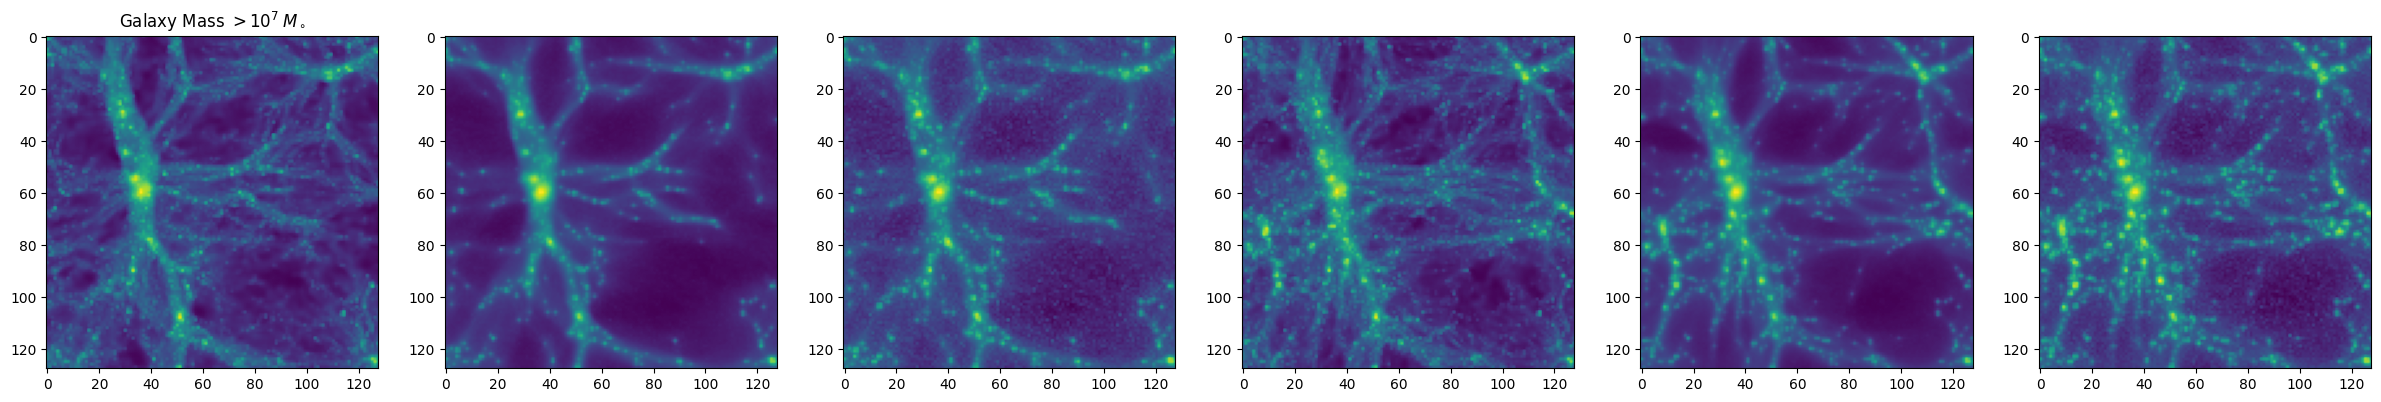

In [278]:
model_names=['VDM_Mstar_Mcdm_c_c_128', 'VDM_Go8_Mcdm_c_c_128', 'VDM_Go9_Mcdm_c_c_128']
titles=[r"Galaxy Mass $> 10^7\:M_\circ$",r"Galaxy Mass $> 10^8\:M_\circ$",r"Galaxy Mass $> 10^9\:M_\circ$"]
plt.figure(figsize=(30,20))
for i,model_name in enumerate(model_names):
    fields=torch.tensor(np.load(f"./data/ICML_v2/{model_name}/CV_1_128/gen_0.npy")).to(device)
    fields_unnorm=dm.unnorm_func(fields,i_channel=1)
    #field_proj_16=fields_unnorm[:,:,:16].sum(2)
    field_proj_32=fields_unnorm[:,:,:32].sum(2)
    field_proj_64=fields_unnorm[:,:,:64].sum(2)
    #sample_16=field_proj_16[0].cpu().numpy()
    sample_32=field_proj_32[0].cpu().numpy()
    post_mean_32=field_proj_32.mean(0).cpu().numpy()
    post_std_32=field_proj_32.std(0,correction=1).cpu().numpy()
    sample_64=field_proj_64[0].cpu().numpy()
    post_mean_64=field_proj_64.mean(0).cpu().numpy()
    post_std_64=field_proj_64.std(0,correction=1).cpu().numpy()

    plt.subplot(3,6,6*i+1)
    plt.imshow(sample_32[0],norm=LogNorm())
    plt.title(titles[i])
    plt.subplot(3,6,6*i+2)
    plt.imshow(post_mean_32[0],norm=LogNorm())
    plt.subplot(3,6,6*i+3)
    plt.imshow(post_std_32[0],norm=LogNorm())
    plt.subplot(3,6,6*i+4)
    plt.imshow(sample_64[0],norm=LogNorm())
    plt.subplot(3,6,6*i+5)
    plt.imshow(post_mean_64[0],norm=LogNorm())
    plt.subplot(3,6,6*i+6)
    plt.imshow(post_std_64[0],norm=LogNorm())
    break

In [279]:
configs=yaml.safe_load(open("./configs.yaml","r"))
#will only use the normalization functions
model_names=['VDM_Mstar_Mcdm_c_c_128']
xs=[]
cs=[]
for model_name in model_names:
    config=configs[model_name]
    dm=utils.get_datamodule(config)
    for i,batch in enumerate(dm.test_dataloader()):
        x=batch["x"].to(device)
        c=batch["conditioning"].to(device)
        x_unnorm=dm.unnorm_func(x,i_channel=1)
        c_unnorm=dm.unnorm_func(c,i_channel=0)+1#overdensity
        x_proj_32=x_unnorm[:,:,:32].sum(2)
        x_proj_64=x_unnorm[:,:,:64].sum(2)
        c_proj_32=c_unnorm[:,:,:32].sum(2)
        c_proj_64=c_unnorm[:,:,:64].sum(2)
        if i==2:
            break
    cs.append((c_proj_32,c_proj_64))

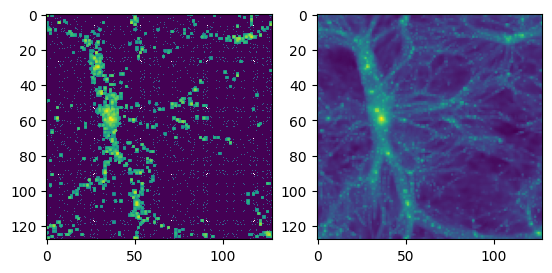

In [280]:
plt.subplot(1,2,1)
plt.imshow(c_proj_32[0,0].cpu().numpy()+0.1,norm=LogNorm())
plt.subplot(1,2,2)
plt.imshow(x_proj_32[0,0].cpu().numpy(),norm=LogNorm())

In [281]:
xx=x_unnorm/torch.sum(x_unnorm,(2,3,4),keepdim=True)
ff=fields_unnorm/torch.sum(fields_unnorm,(2,3,4),keepdim=True)

In [282]:
from mltools.archive import LWT
import importlib
importlib.reload(LWT)

<module 'mltools.archive.LWT' from '/n/home12/cfpark00/MLtools/mltools/archive/LWT.py'>

In [283]:
wavelet_mms, wavelet_vals=LWT.make_wavelets(N=128,
    NR=4,
    NT=4,
    twopi=False,
    dtype=torch.float64,
    #add_z=True,
    #NZ=2,
    return_bases=False,
    verbose=False,
    sqrt=True,)
wavelet_vals=[wv.to(device) for wv in wavelet_vals]

In [284]:
def get_log_rwst(fields):
    wst=LWT.WST_abs2(
        fields[:,0],
        wavelet_mms,
        wavelet_vals,
        m=2,
        verbose=False
    ).cpu().numpy()
    rwst=LWT.get_rwst(wst,NR=4,NT=4)[:,2:]
    return np.log(rwst)

In [285]:
lrwst=get_log_rwst(ff[:,:,:32].sum(2))
lrwst_gt=get_log_rwst(xx[:,:,:32].sum(2))
lrwst.shape,lrwst_gt.shape

((128, 78), (1, 78))

(0.5, 1.5)

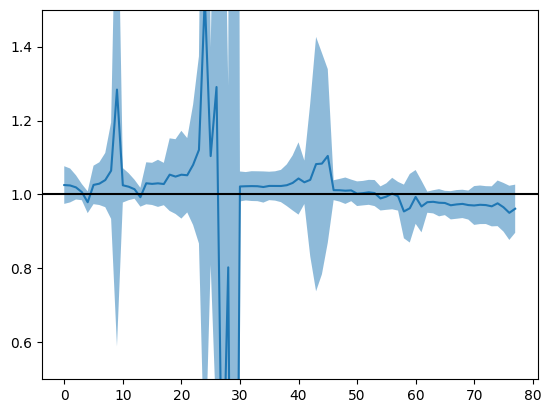

In [286]:
inds=np.arange(lrwst.shape[1])
ratios=lrwst/lrwst_gt[0]
m=np.mean(ratios,0)
s=np.std(ratios,0,ddof=1)
plt.plot(inds,m)
plt.fill_between(inds,m-3*s,m+3*s,alpha=0.5)
plt.axhline(1,c="k")
plt.ylim(0.5,1.5)

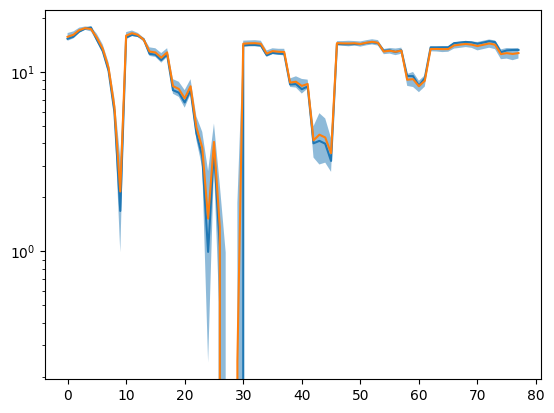

In [287]:
inds=np.arange(lrwst.shape[1])
plt.plot(inds,lrwst_gt[0])
m=np.mean(lrwst,0)
s=np.std(lrwst,0,ddof=1)
plt.plot(inds,m)
plt.fill_between(inds,m-3*s,m+3*s,alpha=0.5)
plt.yscale("log")

In [288]:
ff.shape

torch.Size([128, 1, 128, 128, 128])

In [289]:
from src import utils

In [290]:
xx=x_unnorm/torch.sum(x_unnorm,(2,3,4),keepdim=True)
ff=fields_unnorm/torch.sum(fields_unnorm,(2,3,4),keepdim=True)

In [291]:
kss,pkgts,_=utils.pk(xx)
_,pks,_=utils.pk(ff)
kss=kss[0].cpu().numpy()
pkgt=pkgts[0].cpu().numpy()
pks=pks.cpu().numpy()
pks_10,pks_90=np.percentile(pks,[10,90],axis=0)

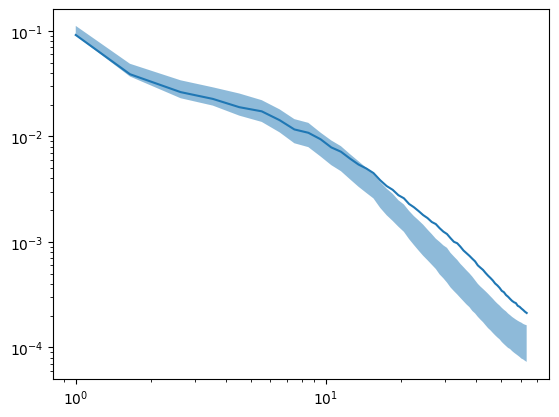

In [292]:
plt.plot(kss,pkgt)
plt.fill_between(kss,pks_10,pks_90,alpha=0.5)
plt.xscale("log")
plt.yscale("log")

In [274]:
kss,pkgts,_=utils.pk(xx[:,:,:32].sum(2))
_,pks,_=utils.pk(ff[:,:,:32].sum(2))
kss=kss[0].cpu().numpy()
pkgt=pkgts[0].cpu().numpy()
pks=pks.cpu().numpy()
pks_20,pks_80=np.percentile(pks,[10,90],axis=0)

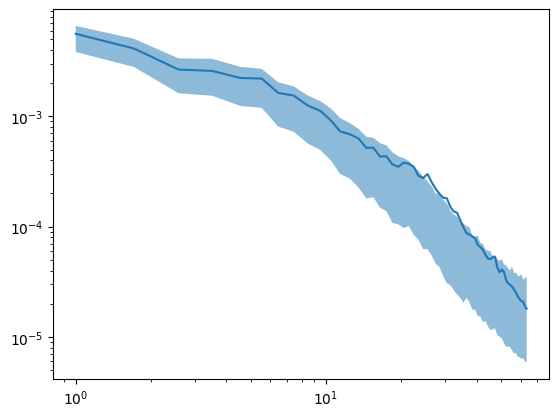

In [275]:
plt.plot(kss,pkgt)
plt.fill_between(kss,pks_20,pks_80,alpha=0.5)
plt.xscale("log")
plt.yscale("log")

In [140]:
x_u_2=x_unnorm[:,:,:64].sum(2)
f_u_2=fields_unnorm[:,:,:64].sum(2)

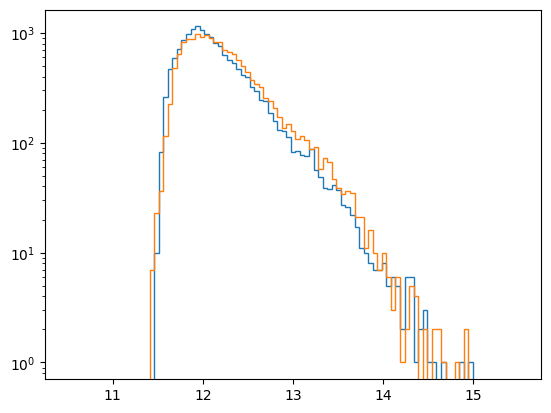

In [141]:
bins=np.linspace(10.5,15.5,100)
_=plt.hist(torch.log10(x_u_2+1).detach().cpu().numpy().flatten(),bins=bins,histtype="step")
_=plt.hist(torch.log10(f_u_2[0]+1).detach().cpu().numpy().flatten(),bins=bins,histtype="step")
plt.yscale("log")

In [144]:
np.load("./data/ICML_v2/VDM_Mstar_Mcdm_c_c_160/CV_12_12/gen_0.npy").shape

(12, 1, 160, 160, 160)

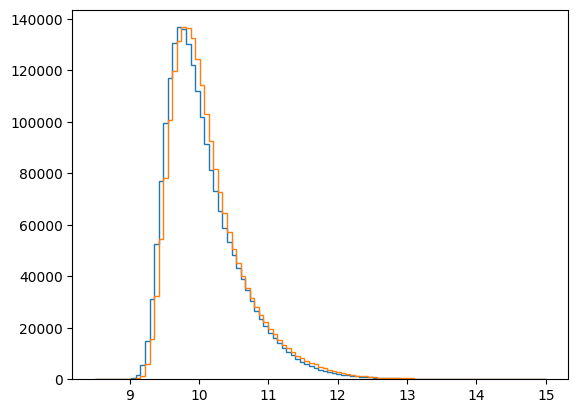

In [129]:
bins=np.linspace(8.5,15,100)
_=plt.hist(torch.log10(x_unnorm+1).detach().cpu().numpy().flatten(),bins=bins,histtype="step")
_=plt.hist(torch.log10(fields_unnorm[0]+1).detach().cpu().numpy().flatten(),bins=bins,histtype="step")
#plt.yscale("log")

In [244]:
summary=torch.load("./data/ICML_v2/VDM_Mstar_Mcdm_c_c_128/summary.pth")

In [245]:
summary["CV_1_128"].keys()

dict_keys(['stats', 'images', 'post_means', 'post_stds'])

In [246]:
post_means=summary["CV_1_128"]["post_means"]
post_means.shape

torch.Size([1, 1, 128, 128, 128])

In [247]:
stats=summary["CV_1_128"]["stats"]
stats.keys()

dict_keys(['Mcdm_GT_0', 'Mcdm_0_0', 'Mcdm_0_1', 'Mcdm_0_2', 'Mcdm_0_3', 'Mcdm_0_4', 'Mcdm_0_5', 'Mcdm_0_6', 'Mcdm_0_7', 'Mcdm_0_8', 'Mcdm_0_9', 'Mcdm_0_10', 'Mcdm_0_11', 'Mcdm_0_12', 'Mcdm_0_13', 'Mcdm_0_14', 'Mcdm_0_15', 'Mcdm_0_16', 'Mcdm_0_17', 'Mcdm_0_18', 'Mcdm_0_19', 'Mcdm_0_20', 'Mcdm_0_21', 'Mcdm_0_22', 'Mcdm_0_23', 'Mcdm_0_24', 'Mcdm_0_25', 'Mcdm_0_26', 'Mcdm_0_27', 'Mcdm_0_28', 'Mcdm_0_29', 'Mcdm_0_30', 'Mcdm_0_31', 'Mcdm_0_32', 'Mcdm_0_33', 'Mcdm_0_34', 'Mcdm_0_35', 'Mcdm_0_36', 'Mcdm_0_37', 'Mcdm_0_38', 'Mcdm_0_39', 'Mcdm_0_40', 'Mcdm_0_41', 'Mcdm_0_42', 'Mcdm_0_43', 'Mcdm_0_44', 'Mcdm_0_45', 'Mcdm_0_46', 'Mcdm_0_47', 'Mcdm_0_48', 'Mcdm_0_49', 'Mcdm_0_50', 'Mcdm_0_51', 'Mcdm_0_52', 'Mcdm_0_53', 'Mcdm_0_54', 'Mcdm_0_55', 'Mcdm_0_56', 'Mcdm_0_57', 'Mcdm_0_58', 'Mcdm_0_59', 'Mcdm_0_60', 'Mcdm_0_61', 'Mcdm_0_62', 'Mcdm_0_63', 'Mcdm_0_64', 'Mcdm_0_65', 'Mcdm_0_66', 'Mcdm_0_67', 'Mcdm_0_68', 'Mcdm_0_69', 'Mcdm_0_70', 'Mcdm_0_71', 'Mcdm_0_72', 'Mcdm_0_73', 'Mcdm_0_74', 'Mcdm_0_75'

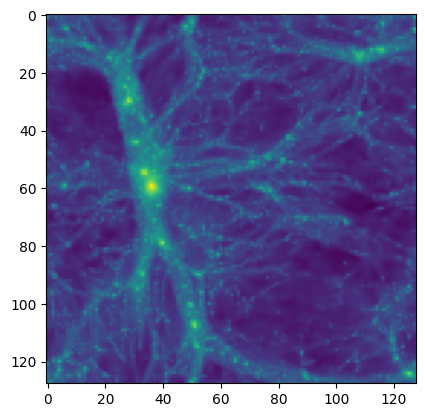

In [251]:
plt.imshow(np.log(summary["CV_1_128"]["images"]['quarter_Mcdm_GT_0'][0,0]))

In [252]:
stats["Mcdm_GT_0"].keys()

dict_keys(['3d_mean', '3d_std', '3d_pk', '3d_logpdf', '2d_half_mean', '2d_half_std', '2d_half_pk', '2d_half_logpdf', '2d_half_rwst', '2d_quarter_mean', '2d_quarter_std', '2d_quarter_pk', '2d_quarter_logpdf', '2d_quarter_rwst'])

In [253]:
stat_name="3d_pk"
sample_stats=[]
for key in stats.keys():
    if "GT" in key:
        gt_stat=stats[key][stat_name]
    else:
        sample_stats.append(stats[key][stat_name])
sample_stats=np.stack(sample_stats,axis=1)

In [254]:
sample_stats.shape

(1, 128, 64)

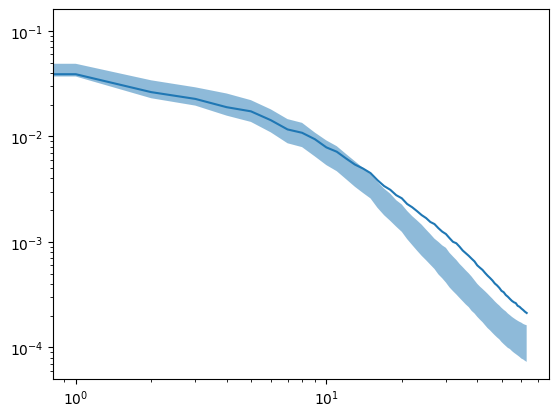

In [255]:
a=np.arange(len(gt_stat[0]))
plt.plot(a,gt_stat[0])
m=np.mean(sample_stats[0],0)
p10,p90=np.percentile(sample_stats[0],[10,90],axis=0)
plt.fill_between(a,p10,p90,alpha=0.5)
plt.yscale("log")
plt.xscale("log")

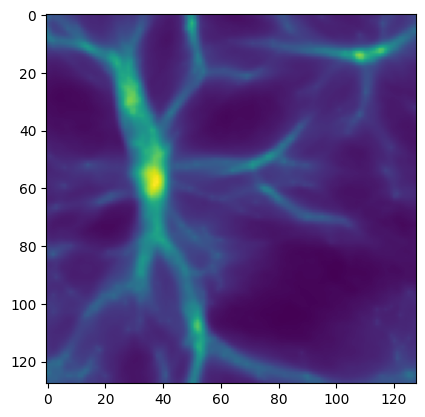

In [170]:
plt.imshow(post_means[0,0,:32].sum(0))

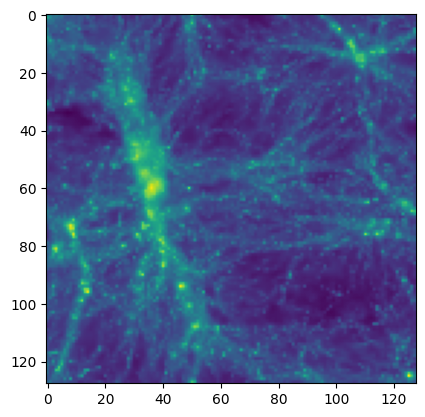

In [162]:
plt.imshow(np.log(summary["CV_1_128"]["images"]["half_Mcdm_0_114"][0,0]+1))

In [130]:
h=np.histogram(torch.log10(x_unnorm+1).detach().cpu().numpy().flatten(),bins=bins)[0]

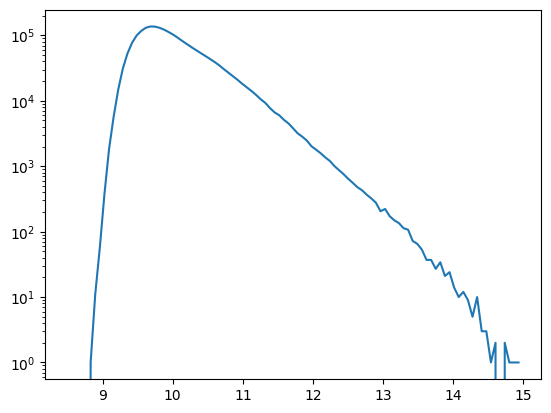

In [131]:
plt.plot(bins[:-1],h)
plt.yscale("log")

In [ ]:
(field_proj_32)
lrwst_gt=get_log_rwst(x_proj_32)

In [83]:
np.isnan(wst[0]).sum()

0

In [76]:
fields.shape,fields.device

(torch.Size([128, 1, 128, 128, 128]), device(type='cuda', index=0))

In [60]:
fields_unnorm[:16].device

device(type='cuda', index=0)

In [37]:
cs[0,0,0,0].min()

-32.0

In [17]:
post_mean_32.shape

(1, 128, 128)

In [ ]:
"./data/ICML_v2/VDM_Go7_Mcdm_c_c_128/CV_1_128/"

In [22]:
tasks=["CV_12_12","CV_1_128"]
model_names=['VDM_Go7_Mcdm_c_c_128', 'VDM_Go8_Mcdm_c_c_128', 'VDM_Go9_Mcdm_c_c_128',
                           'VDM_Mstar_Mcdm_c_c_128', 'VDM_Mstar_Mcdm_c_c_160', 'VDM_Mstar_Mcdm_c_c_192',
                           'VDM_Mstar_Mcdm_c_c_224', 'VDM_Mstar_Mcdm_c_c_256',]

In [23]:
bash_scripts=[]
for task in tasks:
    for model_name in model_names:
        save_dir=f"./data/ICML_v2/{model_name}/{task}"
        bash_script=f"python3 generate_3D.py {model_name} {save_dir} {task}"
        bash_scripts.append(bash_script)

In [24]:
n_proc=6
chunked=[bash_scripts[i::n_proc] for i in range(n_proc)]
for i,chunk in enumerate(chunked):
    with open(f"./scripts/bashrun/run_CV_{i}.sh","w") as f:
        for script in chunk:
            f.write(script+"\n")

In [94]:
tasks=["1P_128"]
model_names=['VDM_Mstar_Mcdm_c_c_128', 'VDM_Mstar_Mcdm_c_c_160', 'VDM_Mstar_Mcdm_c_c_192',
             'VDM_Mstar_Mcdm_c_c_224', 'VDM_Mstar_Mcdm_c_c_256',
             'VDM_Mstar_Mcdm_c_c_256_comp','VDM_Mstar_Mcdm_c_uc_256']

In [95]:
bash_scripts=[]
for task in tasks:
    for model_name in model_names:
        save_dir=f"./data/ICML_v2/{model_name}/{task}"
        bash_script=f"python3 generate_3D_1P.py {model_name} {save_dir} {task}"
        bash_scripts.append(bash_script)

In [96]:
n_proc=6
chunked=[bash_scripts[i::n_proc] for i in range(n_proc)]
for i,chunk in enumerate(chunked):
    with open(f"./scripts/bashrun/run_1P_{i}.sh","w") as f:
        for script in chunk:
            f.write(script+"\n")

In [ ]:
tasks=["CV_12_12","CV_1_128"]
model_names=['SFM_Mstar_Mcdm_c_c_128','SFM_Mstar_Mcdm_c_c_256',
             "LDM"]

In [ ]:
bash_scripts=[]
for task in tasks:
    for model_name in model_names:
        save_dir=f"./data/ICML_v2/{model_name}/{task}"
        bash_script=f"python3 generate_3D_SFM_LDM.py {model_name} {save_dir} {task}"
        bash_scripts.append(bash_script)

In [ ]:
n_proc=6
chunked=[bash_scripts[i::n_proc] for i in range(n_proc)]
for i,chunk in enumerate(chunked):
    with open(f"./scripts/bashrun/run_SFM_LDM_{i}.sh","w") as f:
        for script in chunk:
            f.write(script+"\n")

In [34]:
configs=yaml.safe_load(open("./configs.yaml","r"))
configs.keys()

dict_keys(['VDM_Go7_Mcdm_c_c_128', 'VDM_Go8_Mcdm_c_c_128', 'VDM_Go9_Mcdm_c_c_128', 'VDM_Mstar_Mcdm_c_c_128', 'VDM_Mstar_Mcdm_c_c_160', 'VDM_Mstar_Mcdm_c_c_192', 'VDM_Mstar_Mcdm_c_c_224', 'VDM_Mstar_Mcdm_c_c_256', 'VDM_Mstar_Mcdm_c_c_256_comp', 'VDM_Mstar_Mcdm_c_uc_256', 'SFM_Mstar_Mcdm_c_c_128', 'SFM_Mstar_Mcdm_c_c_256'])

In [35]:
config=configs['VDM_Mstar_Mcdm_c_c_128']

In [36]:
config=configs['VDM_Mstar_Mcdm_c_c_128']
config["data_params"]["set_name"]="1P"
config["data_params"]["stage"]="test"
dm=utils.get_datamodule(config)

In [43]:
xs=[]
ps=[]
cs=[]
for batch in dm.test_dataloader():
    x=batch["x"].detach().cpu().numpy()
    p=batch["conditioning_values"][0].detach().cpu().numpy()
    c=batch["conditioning"]
    xs.append(x)
    ps.append(p)
    cs.append(c)
xs=np.concatenate(xs,axis=0)
ps=np.concatenate(ps,axis=0)
cs=np.concatenate(cs,axis=0)
xs.shape,ps.shape,cs.shape

((61, 1, 128, 128, 128), (61, 6), (61, 1, 128, 128, 128))

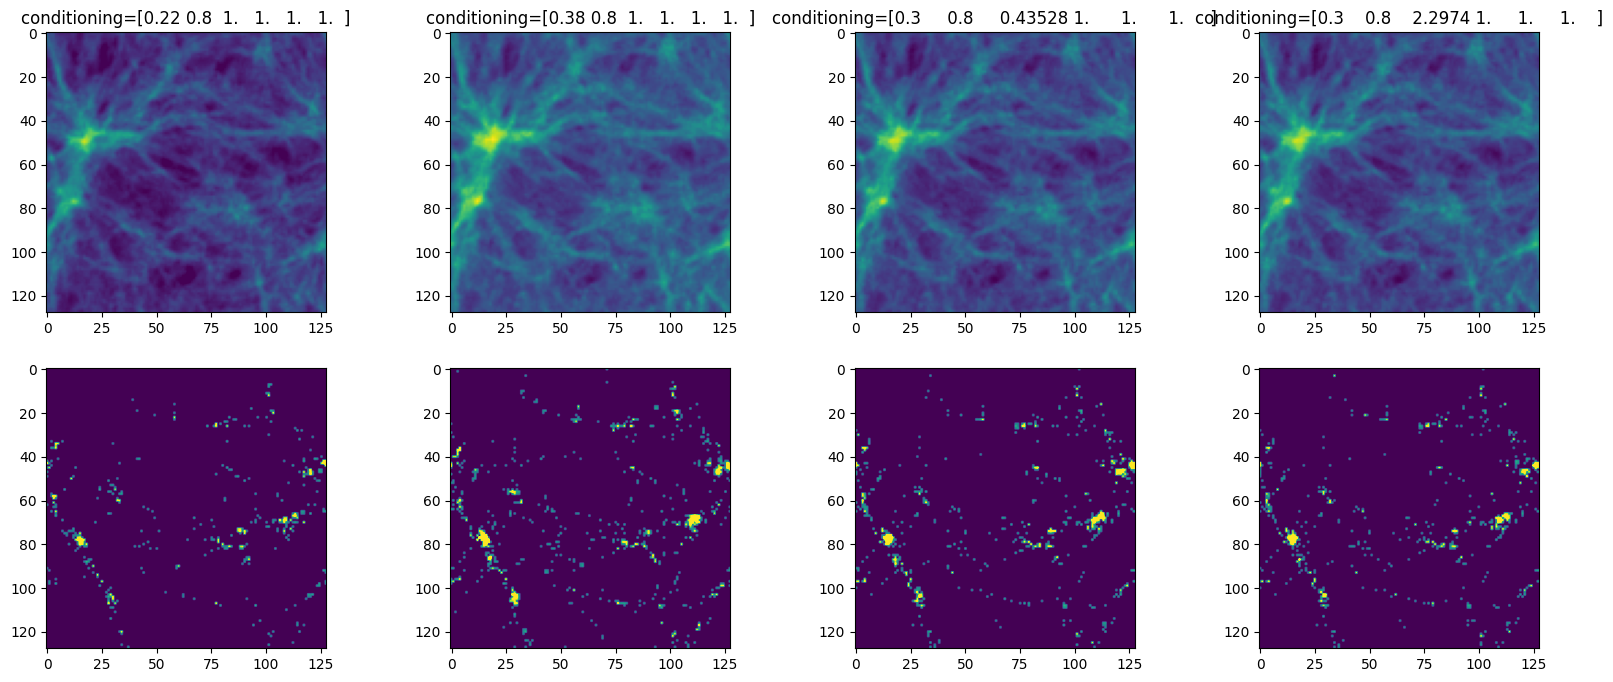

In [90]:
iis=[4,7,23,28]
plt.figure(figsize=(20,8))
for col,i in enumerate(iis):
    plt.subplot(2,len(iis),col+1)
    plt.imshow(xs[i,0].mean(0),vmin=-0.5,vmax=2)
    plt.title(f"conditioning={ps[i]}")
    plt.subplot(2,len(iis),len(iis)+col+1)
    plt.imshow(cs[i,0][:16].mean(0),vmin=0.,vmax=3.5)

In [32]:
ps

array([[0.3    , 0.8    , 1.     , 1.     , 1.     , 1.     ],
       [0.1    , 0.8    , 1.     , 1.     , 1.     , 1.     ],
       [0.14   , 0.8    , 1.     , 1.     , 1.     , 1.     ],
       [0.18   , 0.8    , 1.     , 1.     , 1.     , 1.     ],
       [0.22   , 0.8    , 1.     , 1.     , 1.     , 1.     ],
       [0.26   , 0.8    , 1.     , 1.     , 1.     , 1.     ],
       [0.34   , 0.8    , 1.     , 1.     , 1.     , 1.     ],
       [0.38   , 0.8    , 1.     , 1.     , 1.     , 1.     ],
       [0.42   , 0.8    , 1.     , 1.     , 1.     , 1.     ],
       [0.46   , 0.8    , 1.     , 1.     , 1.     , 1.     ],
       [0.5    , 0.8    , 1.     , 1.     , 1.     , 1.     ],
       [0.3    , 0.6    , 1.     , 1.     , 1.     , 1.     ],
       [0.3    , 0.64   , 1.     , 1.     , 1.     , 1.     ],
       [0.3    , 0.68   , 1.     , 1.     , 1.     , 1.     ],
       [0.3    , 0.72   , 1.     , 1.     , 1.     , 1.     ],
       [0.3    , 0.76   , 1.     , 1.     , 1.     , 1.

In [56]:
dm.test_data.crop.do_augshift#=False

True

In [196]:
from src import utils

In [97]:
#f1=np.load("./data/ICML_v2/VDM_Mstar_Mcdm_c_c_128/CV_12_12/gen_0.npy")
#f2=np.load("./data/ICML_v2/VDM_Go9_Mcdm_c_c_128/CV_12_12/gen_0.npy")
f1=np.load("./data/ICML_v2/VDM_Mstar_Mcdm_c_c_128/1P_128/fid.npy")
#f2=np.load("./data/ICML_v2/
f1.shape

(128, 1, 128, 128, 128)

<Axes: >

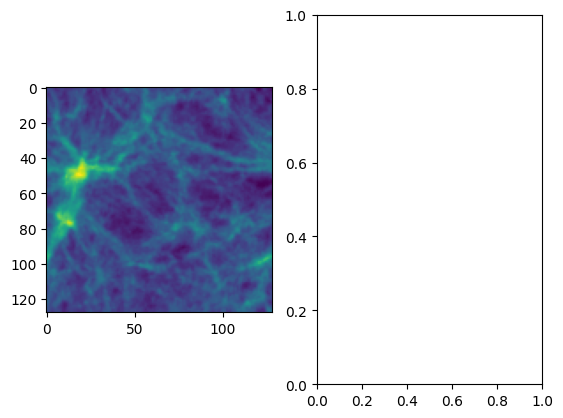

In [99]:
plt.subplot(1,2,1)
plt.imshow(f1[1,0].sum(0))
plt.subplot(1,2,2)
#plt.imshow(f2[0,0].sum(0))

In [25]:
path="/n/holystore01/LABS/itc_lab/Lab/Camels/params/params_1P_Astrid.txt"
path="/n/holystore01/LABS/itc_lab/Lab/Camels/test/params_1P_Astrid.txt"
params=np.loadtxt(path)
params.shape

(61, 6)

In [29]:
configs=yaml.safe_load(open("./configs.yaml","r"))

In [50]:
configs.keys()

dict_keys(['VDM_Go7_Mcdm_c_c_128', 'VDM_Go8_Mcdm_c_c_128', 'VDM_Go9_Mcdm_c_c_128', 'VDM_Mstar_Mcdm_c_c_128', 'VDM_Mstar_Mcdm_c_c_160', 'VDM_Mstar_Mcdm_c_c_192', 'VDM_Mstar_Mcdm_c_c_224', 'VDM_Mstar_Mcdm_c_c_256', 'VDM_Mstar_Mcdm_c_uc_256', 'SFM_Mstar_Mcdm_c_c_128', 'SFM_Mstar_Mcdm_c_c_256'])

In [74]:
gens=[]
for key,config in configs.items():
    if "Go" in key or "SFM" in key:
        continue
    if "256" not in key:
        continue
    print(key)
    model=utils.get_model(config)
    dm=utils.get_datamodule(config)
    for batch in dm.test_dataloader():
        break
    x=batch["x"].to(device)
    s_conditioning=batch["conditioning"].to(device)
    v_conditionings=[d.to(device) for d in batch["conditioning_values"]]
    if config["conditioning_values"]==0:
        v_conditionings=[]
    model.to(device)
    model.eval()
    gen=model.draw_samples(batch_size=s_conditioning.shape[0],s_conditioning=s_conditioning,v_conditionings=v_conditionings,verbose=True)
    gens.append(gen.cpu().detach().numpy())

VDM_Mstar_Mcdm_c_c_256


sampling:   8%|▊         | 21/250 [00:08<01:31,  2.50it/s]


KeyboardInterrupt: 

In [64]:
xs=[]
for batch in dm.test_dataloader():
    xs.append(batch["x"].cpu().detach())
len(xs)

24

In [65]:
nparr=np.load("/n/holystore01/LABS/itc_lab/Lab/Camels/3D_grids_128/Grids_Mcdm_Astrid_CV_128_z=0.0.npy")
indarr=np.ones(nparr.shape[0],dtype=bool)
indarr[[2,8,17]]=0
nparr=nparr[indarr]
nparr.shape

(24, 128, 128, 128)

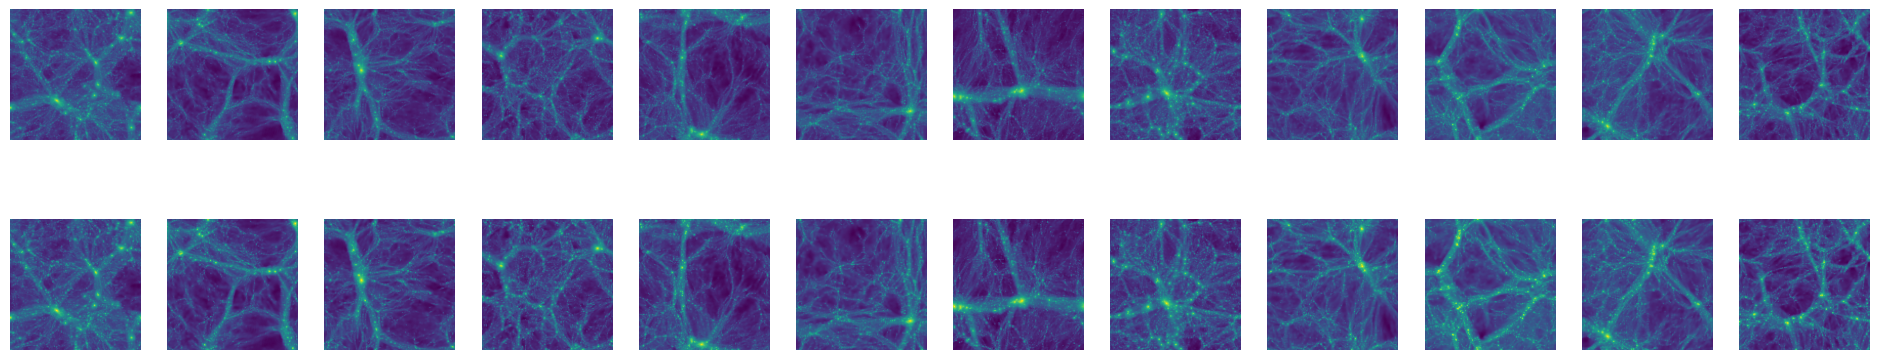

In [72]:
i_show=12
plt.figure(figsize=(24,5))
for i,x in enumerate(xs):
    plt.subplot(2,i_show,i+1)
    plt.imshow(dm.norm_func(dm.unnorm_func(x[0,0][:64],1).sum(0),1))
    plt.axis("off")
    plt.subplot(2,i_show,i_show+i+1)
    plt.imshow(dm.norm_func(torch.tensor(nparr[i][:32].sum(0)),1))
    plt.axis("off")
    if i==i_show-1:
        break

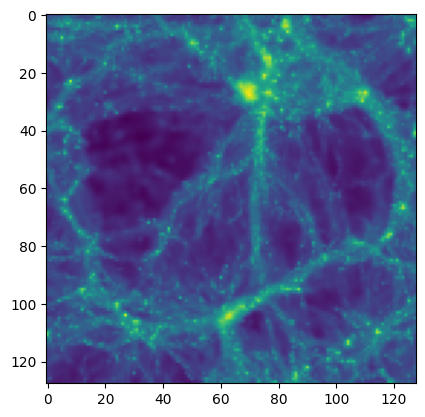

In [49]:
plt.imshow(dm.norm_func(torch.tensor(dm.unnorm_func(gens[0][0,0],i_channel=1)[:32].sum(0)),i_channel=1) )

In [44]:
gens[0].shape

(1, 1, 128, 128, 128)

In [35]:
model.__class__

mltools.models.vdm_model.LightVDM

In [24]:
batch.keys()

dict_keys(['conditioning', 'x', 'conditioning_values'])

In [18]:
for batch in dm.test_dataloader():
    break

In [19]:
batch["x"].shape

torch.Size([1, 1, 256, 256, 256])

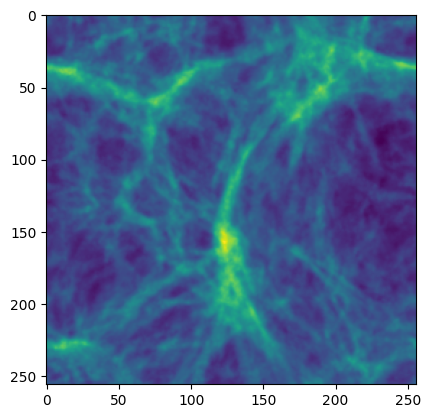

In [20]:
plt.imshow(batch["x"][0,0].sum(-1))

In [13]:
fol="/n/holystore01/LABS/itc_lab/Lab/Camels/subfind_catalog_new/Astrid_CV"
for i in range(27):
    subfol=os.path.join(fol,f"CV_{i}")
    os.makedirs(subfol,exist_ok=True)
